### import modules

In [1]:
# to remove depreciationWarning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))

In [2]:
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

- Import NLTK for common stop words
- This list of stopwords will be extended. The extension words are corpus specific

In [3]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['davao','city','government','ordinance','series'])
# stop_words.extend(['davao', 'city', 'government','ordinance','barangay', 'known','otherwise','thereof','therefor','purposes','mayor','amended', 'series','enter','sign'])
# stop_words.extend(['thereof','shall','barangay','ordinance','known','otherwise','city','davao','government','memorandum','code','sign','mayor','behalf','series','purposes','comprehensive','agreement','enter','section','entered','amended'])
# stop_words.extend(['ordinance','government','series','amending','otherwise','known','davao','city','government','sign','purposes','behalf','authorizing','providing',
# 'section','granting','providing','use','sign','code','thereof','agreement','enter','use','act','ii','xi','article','memorandum','barangay','mayor'])
# stop_words.extend(['ordinance','tagum','city','thereof','section','municipal','municipality','ii','davao','sign','enter','amending','granting','authorizing','behalf','mayor','approving','authority'])

### Import Tagum dataset

In [4]:
df = pd.read_csv('ordinances/davao_ordinances.csv', header = 0)
print(df)
df.head()

            OR                                                 OT
0    000172-14  An Ordinance amending Section 42 of the 2005 R...
1    000177-14  An Ordinance placing underground all electrica...
2    000178-14  An Ordinance amending City Ordinance No. 0195-...
3    000173-14  An Ordinance regulating the use of some street...
4    000227-14  An ordinance for the creation of Trust Fund Ac...
..         ...                                                ...
414  000496-13  An Ordinance authorizing the City Mayor to ent...
415  000487-16  An Ordinance amending Section 13 Article XI of...
416  000348-07  Ordinance  Establishing the Gender-Sensitive C...
417  000349-07  ORDINANCE AMENDING DAVAO CITY ORDINANCE NO. 15...
418  000355-07  An  Ordinance  for  the  "Davao  Branding  Sys...

[419 rows x 2 columns]


,OR,OT
0,000172-14,An Ordinance amending Section 42 of the 2005 R...
1,000177-14,An Ordinance placing underground all electrica...
2,000178-14,An Ordinance amending City Ordinance No. 0195-...
3,000173-14,An Ordinance regulating the use of some street...
4,000227-14,An ordinance for the creation of Trust Fund Ac...


Add ordinance descriptions to a list

In [5]:
data = list(df.OT) 
print(data[:1]) # preview

['An Ordinance amending Section 42 of the 2005 Revenue Code of Davao City from "Time and Place of the Payment - The tax shall be due and payable in advance to the City Treasurer or his duly authorized representative before the materials are extracted and shall be based on the volume applied for in the application for quarry concession" to "Tax shall be due and payable every quarter of the Calendar Year to the City Treasurer or his duly authorized representative after the materials are extracted based on the volume applied for in the application for quarry concession"']


Use regular expression to remove words ending with ING.
(Seems to improve topics)

In [6]:
import re
newStops = []
i = 0
# add words next to ordinance to stops words list 
while i < len(data):
    try:
        newStops.append(re.search(r'(?<=Ordinance )(\w+)', data[i]).group(1))
    except AttributeError:
        None
    i +=1
stop_words.extend(newStops)
print(len(data))
# print(new)

419


Tokenize and preprocess text

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:1])

[['an',
  'ordinance',
  'amending',
  'section',
  'of',
  'the',
  'revenue',
  'code',
  'of',
  'davao',
  'city',
  'from',
  'time',
  'and',
  'place',
  'of',
  'the',
  'payment',
  'the',
  'tax',
  'shall',
  'be',
  'due',
  'and',
  'payable',
  'in',
  'advance',
  'to',
  'the',
  'city',
  'treasurer',
  'or',
  'his',
  'duly',
  'authorized',
  'representative',
  'before',
  'the',
  'materials',
  'are',
  'extracted',
  'and',
  'shall',
  'be',
  'based',
  'on',
  'the',
  'volume',
  'applied',
  'for',
  'in',
  'the',
  'application',
  'for',
  'quarry',
  'concession',
  'to',
  'tax',
  'shall',
  'be',
  'due',
  'and',
  'payable',
  'every',
  'quarter',
  'of',
  'the',
  'calendar',
  'year',
  'to',
  'the',
  'city',
  'treasurer',
  'or',
  'his',
  'duly',
  'authorized',
  'representative',
  'after',
  'the',
  'materials',
  'are',
  'extracted',
  'based',
  'on',
  'the',
  'volume',
  'applied',
  'for',
  'in',
  'the',
  'application',
  'f

In [8]:
# Remove Stop Words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)

# Create Dictionary
id2word = corpora.Dictionary(data_words_nostops)

# Create Corpus
texts = data_words_nostops

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 2), (3, 2), (4, 2), (5, 1), (6, 1), (7, 2), (8, 2), (9, 2), (10, 1), (11, 2), (12, 2), (13, 2), (14, 1), (15, 1), (16, 2), (17, 1), (18, 2), (19, 1), (20, 1), (21, 2), (22, 1), (23, 2), (24, 2), (25, 1)]]


In [9]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('advance', 1),
  ('application', 2),
  ('applied', 2),
  ('authorized', 2),
  ('based', 2),
  ('calendar', 1),
  ('code', 1),
  ('concession', 2),
  ('due', 2),
  ('duly', 2),
  ('every', 1),
  ('extracted', 2),
  ('materials', 2),
  ('payable', 2),
  ('payment', 1),
  ('place', 1),
  ('quarry', 2),
  ('quarter', 1),
  ('representative', 2),
  ('revenue', 1),
  ('section', 1),
  ('tax', 2),
  ('time', 1),
  ('treasurer', 2),
  ('volume', 2),
  ('year', 1)]]

In [10]:
# Build LDA model

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,workers=3,
                                           num_topics=15, 
                                           random_state=123,
                                           
                                           chunksize=100,
                                           passes=30,
                                          
                                           per_word_topics=True)

In [11]:
doc_lda = lda_model[corpus]

In [12]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=123,
                                           chunksize=100,
                                           passes=30,
                                           workers=3,
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

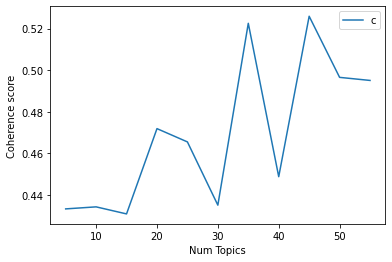

Model: ( 0 ) Num Topics = 5  has Coherence Value of 0.4333
Model: ( 1 ) Num Topics = 10  has Coherence Value of 0.4342
Model: ( 2 ) Num Topics = 15  has Coherence Value of 0.4309
Model: ( 3 ) Num Topics = 20  has Coherence Value of 0.4719
Model: ( 4 ) Num Topics = 25  has Coherence Value of 0.4655
Model: ( 5 ) Num Topics = 30  has Coherence Value of 0.4351
Model: ( 6 ) Num Topics = 35  has Coherence Value of 0.5225
Model: ( 7 ) Num Topics = 40  has Coherence Value of 0.4488
Model: ( 8 ) Num Topics = 45  has Coherence Value of 0.5259
Model: ( 9 ) Num Topics = 50  has Coherence Value of 0.4965
Model: ( 10 ) Num Topics = 55  has Coherence Value of 0.495


In [13]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=5, limit=60, step=5)

# Show graph to find optimal number of topics
# Coherence value not going flat seems unlikely or probably wrong
limit=60; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
model_number = -1
for m, cv in zip(x, coherence_values):
    model_number += 1
    print("Model: (", model_number,") Num Topics =", m, " has Coherence Value of", round(cv, 4))

K = 15 is the optimal number of topics since when

In [14]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.027*"provisions" + 0.024*"maintenance" + 0.023*"operation" + '
  '0.021*"center" + 0.020*"certain" + 0.020*"establishment" + '
  '0.014*"recreation" + 0.014*"dcrc" + 0.011*"use" + 0.011*"subject"'),
 (1,
  '0.042*"behalf" + 0.041*"memorandum" + 0.038*"agreement" + 0.033*"entered" + '
  '0.033*"health" + 0.018*"development" + 0.016*"department" + 0.014*"center" '
  '+ 0.014*"office" + 0.014*"relative"'),
 (2,
  '0.014*"donation" + 0.014*"acts" + 0.013*"penalties" + 0.012*"within" + '
  '0.012*"gender" + 0.012*"lot" + 0.011*"deed" + 0.010*"executed" + '
  '0.010*"favor" + 0.010*"authority"'),
 (3,
  '0.043*"section" + 0.024*"code" + 0.020*"revenue" + 0.016*"particularly" + '
  '0.011*"paragraph" + 0.010*"within" + 0.010*"act" + 0.010*"number" + '
  '0.009*"development" + 0.009*"legal"'),
 (4,
  '0.031*"use" + 0.024*"public" + 0.017*"birthing" + 0.016*"market" + '
  '0.016*"home" + 0.016*"prescribing" + 0.014*"health" + 0.014*"designating" + '
  '0.013*"dabawenyo" + 0.012*"code"

In [15]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,16.0,0.9774,"comprehensive, per, code, land, day, public, d...",An Ordinance amending Section 42 of the 2005 R...
1,1,3.0,0.9050,"section, code, revenue, particularly, paragrap...",An Ordinance placing underground all electrica...
2,2,9.0,0.8417,"internet, development, cafe, operation, projec...",An Ordinance amending City Ordinance No. 0195-...
3,3,4.0,0.7825,"use, public, birthing, market, home, prescribi...",An Ordinance regulating the use of some street...
4,4,4.0,0.7540,"use, public, birthing, market, home, prescribi...",An ordinance for the creation of Trust Fund Ac...
5,5,18.0,0.6833,"halal, code, business, food, investment, estab...",An ordinance amending the Tourism Code of Dava...
6,6,12.0,0.9500,"memorandum, behalf, agreement, program, depart...",An Ordinance granting Legislative Authority to...
7,7,2.0,0.3474,"donation, acts, penalties, within, gender, lot...",An ordinance granting legislative authority to...
8,8,3.0,0.8100,"section, code, revenue, particularly, paragrap...",An Ordinance regulating motorcades within the ...
9,9,1.0,0.6703,"behalf, memorandum, agreement, entered, health...","An ordinance authorizing the City Mayor, Rodri..."


In [16]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 1000

documents_topic = pd.DataFrame()


sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head(55)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9472,"provisions, maintenance, operation, center, certain, establishment, recreation, dcrc, use, subject",Mandating and regulating the creation of a Committee on Decorum and Investigation (CODI) in every office in both public and private sectors for the purpose of investigating cases of sexual harassment and job discrimination
1,1.0,0.9721,"behalf, memorandum, agreement, entered, health, development, department, center, office, relative","An Ordinance granting legislative authority to the City Mayor to enter into and sign, for and in behalf of the City Government of Davao, the Memorandum of Understanding (MOU) to be entered into by and between the City Government of Davao and Korea Engineering and Construction Co., Ltd. (KEC), represented by Mr. Seol Young Man, Chief Executive Officer, for the conduct of a master plan and and pre-feasibility studies for the Davao Light Rail Trnasit (LRT) Railway Project"
2,2.0,0.9729,"donation, acts, penalties, within, gender, lot, deed, executed, favor, authority","An ordinance granting legislative authority to the City Mayor to accept and sign, for and in behalf of the City Government of Davao, the Deed of Donation to be executed by datu Pamikiren Latip P. Ayunandatu Arumpac Jr., Librada P. Rufo, JEster G. Oani, Rodolfo C. Catahum, Porferia Valles, Oscar M. Figuracion Jr., and Hon. Halila Y. Sudagar, in favor of the City Government of Davao, relative to the donation of various artifacts for Museo Dabawenyo"
3,3.0,0.9721,"section, code, revenue, particularly, paragraph, within, act, number, development, legal","AN ORDINANCE AUTHORIZING THE CITY MAYOR TO IMPLEMENT THE ADJUSTED RATES OF SPECIAL COUNSEL ALLOWANCE PAID TO LAWYER-PERSONNEL INCLUDING THOSE DESIGNATED TO ASSUME THE DUTIES OF A LEGAL OFFICER AND THOSE IN THE LEGAL STAFF OF DEPARTMENTS, BUREAUS, AND OFFICES IN THE CITY GOVERNMENT OF DAVAO EFFECTIVE JANUARY 2010 ON THE BASIS OF SECTION 52 OF REPUBLIC ACT NO. 9970 OR THE GENERAL APPROPRIATIONS ACT OF FISCAL YEAR 2010 (GAA FY 2010)"
4,4.0,0.9721,"use, public, birthing, market, home, prescribing, health, designating, dabawenyo, code","An Ordinance enjoining all individuals, private and public offices or entities to use ""Kagan"" not ""Kalagan"" in their files, data, records and other documents when referring to the Kagan Tribe as defined in this Act, for publication, public display, public use and for other purposes and to correct all their existing files, data, records, and other documents to reflect the tribe`s name as ""Kagan"" not ""Kalagan"""
5,5.0,0.9635,"authority, legislative, inc, support, self, tower, meter, globe, district, provided","AN ORDINANCE GRANTING LEGISLATIVE AUTHORITY TO EFB GEOSTRUCKT, INC. FOR THE CONSTUCTION, INSTALLATION AND OPERATION OF GLOBE TELECOM`S 40.0 METER 3-LEGGED SELF SUPPORT CELL SITE TOWER AT TIGATTO ROAD, BREAD VILLAGE, BARANGAY BUHANGIN PROPER, BUHANGIN DISTRICT,THIS CITY"
6,6.0,0.9743,"street, phase, tibungco, people, funds, section, senior, citizens, riders, scheme","Ordinance further amending Ordinance No. 737, series of 1978, by requiring drivers and riders of single motorcycles plying along the city streets and national highways within the territorial jurisdiction of Davao City to wear crash helmets while operating or riding on said motorcycles, limiting the number of back riders or riders thereof to only one (1) person; strictly prohibiting the use of single motorcycles as public transport units or conveyances, and imposing penalties for violations thereof"
7,7.0,0.9784,"fund, five, hundred, construction, management, amount, pesos, classrooms, thousand, reduction","AN ORDINANCE GRANTING LEGISLATIVE AUTHORITY TO THE CITY MAYOR TO SIGN, FOR AND IN BEHALF OF THE CITY GOVERNMENT OF DAVAO, THE SPECIFIC IMPLEMENTATION ARRANGEMENTS FOR THE CONSTRUCTION OF CLASSROOMS FOR LUMADS, TO BE ENTERED INTO BY AND AMONG THE CITY GOVERNMENT OF DAVAO, THE DEPARTMENT OF SOCIAL WELFARE AND DEVELOPMEN

In [22]:
# df_sorted_by_topic = df_dominant_topic.sort_values(by=['Dominant_Topic'])
# documents with topic 7.0 as dominant topic
df_sorted_by_topic = df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 1.0]

df_sorted_by_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
9,9,1.0,0.6703,"behalf, memorandum, agreement, entered, health, development, department, center, office, relative","An ordinance authorizing the City Mayor, Rodrigo R. Duterte, to enter into and sign, for and in behalf of the City Government of Davao, the Memorandum of Understanding (MOU) of the Friendship City Agreement between Davao City and Lucena City"
54,54,1.0,0.6833,"behalf, memorandum, agreement, entered, health, development, department, center, office, relative","Ordinance approving the ""Health and Sanitation Ordinance of the City of Davao"""
71,71,1.0,0.6386,"behalf, memorandum, agreement, entered, health, development, department, center, office, relative","An Ordinance requiring senior citizens, persons with disability (PWDs), and minors or persons below eighteen (18) years of age to mandatorily wear lifejackets, by Vessel Operators or Vessel Captains, while on board Vessels, and providing penalties for violation thereof"
73,73,1.0,0.4662,"behalf, memorandum, agreement, entered, health, development, department, center, office, relative","An Ordinance authorizing the City Mayor to enter into and sign, for and in behalf of the City Government of Davao, the Sister City Agreement to be entered into by and between the City of Davao and the City of Bacoor"
117,117,1.0,0.4974,"behalf, memorandum, agreement, entered, health, development, department, center, office, relative","An Ordinance granting legislative authority to the City Mayor to enter into and sign, for and in behalf of the City Government of Davao, the amended Memorandum of Agreement (MOA) between the City Government of Davao (CGD) and Land Bank of the Philippines (LBP) relative to the livelihood/salary loan facility for City Government Employees"
174,174,1.0,0.4419,"behalf, memorandum, agreement, entered, health, development, department, center, office, relative","Ordinance creating the City Cooperative Development Office (CCDO), appropriating funds therefor, and for other purposes"
184,184,1.0,0.8450,"behalf, memorandum, agreement, entered, health, development, department, center, office, relative","An Ordinance authorizing the City Mayor to enter into and sign, for and in behalf of the City Government of Davao, the Memorandum of Agreement to be entered into by and between the City Government of Davao and the Department of Education, implementing the project ""Sa Paaralan Ko, Pwede Nang Magrehistro"""
185,185,1.0,0.9721,"behalf, memorandum, agreement, entered, health, development, department, center, office, relative","An Ordinance granting legislative authority to the City Mayor to enter into and sign, for and in behalf of the City Government of Davao, the Memorandum of Understanding (MOU) to be entered into by and between the City Government of Davao and Korea Engineering and Construction Co., Ltd. (KEC), represented by Mr. Seol Young Man, Chief Executive Officer, for the conduct of a master plan and and pre-feasibility studies for the Davao Light Rail Trnasit (LRT) Railway Project"
191,191,1.0,0.9587,"behalf, memorandum, agreement, entered, health, development, department, center, office, relative","AN ORDINANCE GRANTING THE CITY MAYOR SARA Z. DUTERTE LEGISLATIVE AUTHORITY TO SIGN, FOR AND IN BEHALF OF THE CITY GOVERNMENT OF DAVAO, THE MEMORANDUM OF AGREEMENT TO BE ENTERED INTO BY AND BETWEEN THE CITY GOVERNMENT OF DAVAO AND THE DEPARTMENT OF EDUCATION (DepEd), RELATIVE TO THE IMPLEMENTATION OF THE PROJECT OF THE CITY CIVIL REGISTRAR ENTITLED “SA PAARALAN KO, PWEDE NG MAGREHISTRO”"
213,213,1.0,0.4101,"behalf, memorandum, agreement, entered, health, development, department, center, office, relative",The Davao (Bangoy) International Airport Safety Ordinance of 2007


In [18]:
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
pyLDAvis.display(vis)



/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [19]:
# # 1. Wordcloud of Top N words in each topic
# from matplotlib import pyplot as plt
# from wordcloud import WordCloud, STOPWORDS
# import matplotlib.colors as mcolors

# cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

# cloud = WordCloud(stopwords=stop_words,
#                   background_color='white',
#                   width=2500,
#                   height=1800,
#                   max_words=15,
#                   colormap='tab20',
#                   color_func=lambda *args, **kwargs: cols[i],
#                   prefer_horizontal=1.0)

# topics = optimal_model.show_topics(num_topics=15,formatted=False)

# fig, axes = plt.subplots(3, 5, figsize=(12,8), sharex=True, sharey=True)

# for i, ax in enumerate(axes.flatten()):
#     fig.add_subplot(ax)
#     topic_words = dict(topics[i][1])
#     cloud.generate_from_frequencies(topic_words, max_font_size=300)
#     plt.gca().imshow(cloud)
#     plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
#     plt.gca().axis('off')


# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
# plt.margins(x=0, y=0)
# plt.tight_layout()
# plt.show()

In [20]:
# import seaborn as sns
# import matplotlib.colors as mcolors
# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

# fig, axes = plt.subplots(3,5,figsize=(12,8), dpi=160, sharex=True, sharey=True)
# # These are the "Tableau 20" colors as RGB.    
# tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
#              (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
#              (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
#              (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
#              (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
# for i in range(len(tableau20)):    
#     r, g, b = tableau20[i]    
#     tableau20[i] = (r / 255., g / 255., b / 255.)
    
# for i, ax in enumerate(axes.flatten()):    
#     df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
#     doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
#     ax.hist(doc_lens, bins = 700, color=tableau20[i])
#     ax.tick_params(axis='y', labelcolor=tableau20[i], color=tableau20[i])
#     sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
#     ax.set(xlim=(0, 700), xlabel='Document Word Count')
#     ax.set_ylabel('Number of Documents', color=tableau20[i])
#     ax.set_title('Topic: '+str(i), fontdict=dict(size=5, color=tableau20[i]))

# fig.tight_layout()
# fig.subplots_adjust(top=0.90)
# plt.xticks(np.linspace(0,700,9))
# fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
# plt.show()

In [21]:

# # Sentence Coloring of N Sentences
# from matplotlib.patches import Rectangle

# def sentences_chart(lda_model=optimal_model, corpus=corpus, start = 0, end = 15):
#     corp = corpus[start:end]
#     mycolors = tableau20

#     fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
#     axes[0].axis('off')
#     for i, ax in enumerate(axes):
#         if i > 0:
#             corp_cur = corp[i-1] 
#             topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
#             word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
#             ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
#                     fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

#             # Draw Rectange
#             topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
#             ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
#                                    color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

#             word_pos = 0.06
#             for j, (word, topics) in enumerate(word_dominanttopic):
#                 if j < 14:
#                     ax.text(word_pos, 0.5, word,
#                             horizontalalignment='left',
#                             verticalalignment='center',
#                             fontsize=16, color=mycolors[topics],
#                             transform=ax.transAxes, fontweight=700)
#                     word_pos += .009 * len(word)  # to move the word for the next iter
#                     ax.axis('off')
#             ax.text(word_pos, 0.5, '. . .',
#                     horizontalalignment='left',
#                     verticalalignment='center',
#                     fontsize=16, color='black',
#                     transform=ax.transAxes)       

#     plt.subplots_adjust(wspace=0, hspace=0)
#     plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
#     plt.tight_layout()
#     plt.show()

# sentences_chart()